# Analysis of  StarTracker - Serpent Walk

Bryan: 

```so we took many 10 minute tracks at 4 azimuths last night.  we found some discontinuities in the position reported after the TMA faulted.  my question is has this happened before?  have there been jumps in the encoders and are they always after a fault?  a particular kind of fault?```


## Questions
1. When the TMA faulted?
2. Are the jump in the enconders related to the TMA fault?
3. Is there a particular to the TMA fault?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function to read in the metadata that has been downloaded
import pandas as pd
def read_rubintv(fname):
    df = pd.read_json(fname).T
    df = df.dropna()
    times = df[['UTC','UTC wide']]
    
    df = df.drop(columns=['UTC','UTC wide'])
    df = df.astype(float)
    
    # set time vectors
    timenew = (today+'T'+ times['UTC'].to_numpy()).astype(np.datetime64)
    timenew2= (today+'T'+ times['UTC wide'].to_numpy()).astype(np.datetime64)
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [39]:
def get_groups(df):
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    groups = np.zeros(ra.size, dtype=int)
    snakes = np.zeros(ra.size, dtype=int)
    
    diffRa = np.diff(ra)
    diffDec = np.diff(dec)
    dPnt = np.hypot(diffDec, diffRa)
    
    counter = 0
    for i in range(diffRa.size):
        if  (dPnt[i]>10.): counter += 1
        snakes[i+1] = counter

    counter = 0
    for i in range(diffRa.size):
        if  (dPnt[i]>1/60)&(dPnt[i]<10.): counter += 1
        groups[i+1] = counter

    df['groups'] = groups
    df['snakes'] = snakes
    
    print('Number of Snakes:%i'%np.unique(snakes).size)
    return df

In [40]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y):
    isnan = np.isnan(x)
    coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    return np.append(coefs, np.sqrt(cov[1,1]))

def get_residual(df):    
    groups = df['groups'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    for ix in keys:
        #base_ra[ix] = ra[ix][0]
        #base_dec[ix] = dec[ix][0]
        
        base_ra[ix] = np.median(ra[ix])
        base_dec[ix] = np.median(dec[ix])
    
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600
    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    
    return res_ra, res_dec, base_ra, base_dec

## 15th March

In [41]:
# read in dataframe
today = '2023-03-15'
fname = 'startracker_%s.json'%today
df = read_rubintv(fname)

In [42]:
df

,Exposure Time,MJD,Ra,Dec,Alt,Az,Exposure Time wide,MJD wide,Ra wide,Dec wide,...,Delta Ra Arcsec wide,Delta Dec Arcsec wide,Delta Alt Arcsec wide,Delta Az Arcsec wide,Delta Rot Arcsec wide,RMS scatter arcsec wide,RMS scatter pixels wide,UTC,UTC wide,seq_num
16,4.0,60019.032079,69.314614,-22.739458,49.761442,269.865405,5.0,60019.032085,69.314541,-22.739458,...,43.943739,42.028340,16.542249,63.963622,556795.719937,4.324992,0.499165,2023-03-15 00:46:11,2023-03-15 00:46:12,16
17,4.0,60019.035785,69.314615,-22.739463,48.605764,269.202412,5.0,60019.035791,69.314608,-22.739463,...,45.643037,41.347175,17.913970,62.163208,556846.021862,4.402795,0.508121,2023-03-15 00:51:31,2023-03-15 00:51:32,17
18,4.0,60019.035895,69.314695,-22.739527,48.571663,269.182973,5.0,60019.035900,69.314592,-22.739495,...,45.465671,41.482594,17.928173,62.330570,556846.399862,4.434508,0.511789,2023-03-15 00:51:41,2023-03-15 00:51:41,18
19,4.0,60019.036003,69.314565,-22.739495,48.537918,269.163890,5.0,60019.036009,69.314528,-22.739464,...,46.045447,40.995808,18.580619,61.922826,556849.466382,4.356237,0.502745,2023-03-15 00:51:50,2023-03-15 00:51:51,19
20,4.0,60019.036111,69.314639,-22.739495,48.504173,269.144779,5.0,60019.036117,69.314660,-22.739463,...,45.632353,41.405223,17.768668,62.064994,556851.203094,4.410478,0.509007,2023-03-15 00:52:00,2023-03-15 00:52:00,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,4.0,60019.419165,72.471117,-84.791800,25.000461,179.767048,5.0,60019.419290,72.471101,-84.791801,...,502.411984,-89.643015,101.526278,52.933995,809980.585765,2.815948,0.324920,2023-03-15 10:03:35,2023-03-15 10:03:46,1861
1862,4.0,60019.419285,72.471050,-84.791800,25.000616,179.762676,5.0,60019.419411,72.471199,-84.791801,...,504.865534,-89.555327,101.399094,53.308758,810125.977127,2.602044,0.300175,2023-03-15 10:03:46,2023-03-15 10:03:57,1862
1863,4.0,60019.419405,72.471064,-84.791800,25.000774,179.758257,5.0,60019.419531,72.471133,-84.791801,...,502.944897,-89.635500,101.449320,53.219634,810273.844551,2.533019,0.292225,2023-03-15 10:03:56,2023-03-15 10:04:07,1863
1864,4.0,60019.419525,72.471162,-84.791801,25.000932,179.753886,5.0,60019.419652,72.471063,-84.791799,...,501.209953,-89.419208,101.197157,53.108565,810419.153419,2.633364,0.303793,2023-03-15 10:04:07,2023-03-15 10:04:17,1864


In [43]:
df.columns

Index(['Exposure Time', 'MJD', 'Ra', 'Dec', 'Alt', 'Az', 'Exposure Time wide',
       'MJD wide', 'Ra wide', 'Dec wide', 'Alt wide', 'Az wide',
       'nSources wide', 'nSources filtered wide', 'nSources',
       'nSources filtered', 'Calculated Ra', 'Calculated Dec',
       'Calculated Alt', 'Calculated Az', 'Delta Ra Arcsec',
       'Delta Dec Arcsec', 'Delta Alt Arcsec', 'Delta Az Arcsec',
       'Delta Rot Arcsec', 'RMS scatter arcsec', 'RMS scatter pixels',
       'Calculated Ra wide', 'Calculated Dec wide', 'Calculated Alt wide',
       'Calculated Az wide', 'Delta Ra Arcsec wide', 'Delta Dec Arcsec wide',
       'Delta Alt Arcsec wide', 'Delta Az Arcsec wide',
       'Delta Rot Arcsec wide', 'RMS scatter arcsec wide',
       'RMS scatter pixels wide', 'UTC', 'UTC wide', 'seq_num'],
      dtype='object')

Text(0.5, 1.0, 'Az/Alt Grid - 2023-03-15')

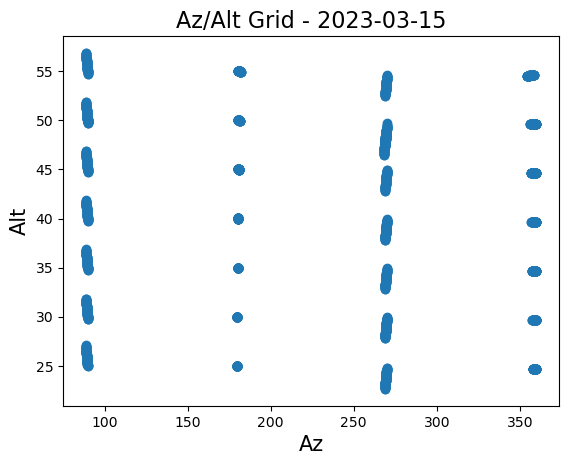

In [95]:
az = df['Calculated Az wide'][:].to_numpy()
alt = df['Calculated Alt wide'][:].to_numpy()
az_slice = np.where(az>87.5)

plt.scatter(az[az_slice], alt[az_slice])
plt.xlabel('Az',fontsize=15)
plt.ylabel('Alt',fontsize=15)
plt.title('Az/Alt Grid - 2023-03-15',fontsize=16)

Text(0.5, 0, 'Alt deg')

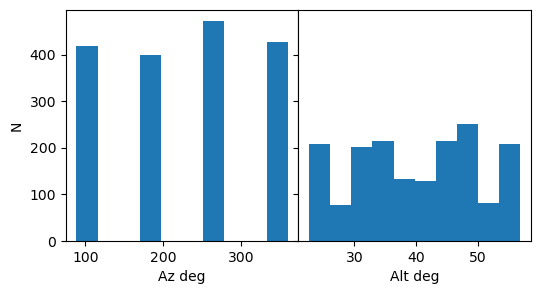

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(6,3), sharey='all')
fig.subplots_adjust(wspace=0.)
ax1.hist(az[az_slice])
ax2.hist(alt[az_slice])
ax1.set_ylabel('N')
ax1.set_xlabel('Az deg')
ax2.set_xlabel('Alt deg')

The grid is not perfect. In Az the number of exposures is about the same. Howeveer in Alt there are some scatter.

### Jumps/TMA Faults

Text(0.5, 0, 'Seq num')

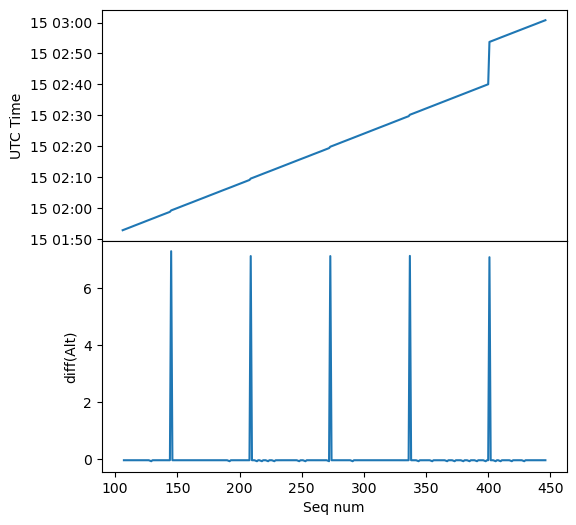

In [97]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(6,6), sharex='all')
fig.subplots_adjust(hspace=0.)
df['Alt'][81:400].diff().plot(ax=ax2)
df['UTC'][81:400].plot(ax=ax1)
ax1.set_ylabel('UTC Time')
ax2.set_ylabel('diff(Alt)')
ax2.set_xlabel('Seq num')

The TMA fault happend around the Seq_num = 400.

In [45]:
# sequences = [ [600,646],  [646,946],  [949,982], [983,1115]]
# sequences = [ [600,643] ]
sequences = [ [81, 400] ]
# sequences = [ [600,646],  [646,910]]
indices = np.empty((0,),dtype=int)

for i0, ie in sequences:
    indices = np.append(indices, np.arange(i0,ie,1,dtype=int))
indices[::5]

array([ 81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141,
       146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206,
       211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271,
       276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336,
       341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396])

In [46]:
# selection of the sequences
data = df.iloc[indices].reset_index() 
print(('Positions for ' + str(data.seq_num.iloc[0]) + ' to ' + str(data.seq_num.iloc[-1])))
first_attempt_circle = get_groups(data)

Positions for 106 to 446
Number of Snakes:2


In [47]:
# check groups
# each group should have 3 exposures
_, _, counts = np.unique(data['groups'].to_numpy(), return_index=True, return_counts=True)
counts

array([38, 63, 57, 63, 98])

In [48]:
# mask = (counts==3)|(counts==4)
# np.unique(snakes, return_counts=True)

In [49]:
res_ra, res_dec, base_ra, base_dec = get_residual(data)

snakes = data['snakes'].to_numpy()
keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]
keys[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

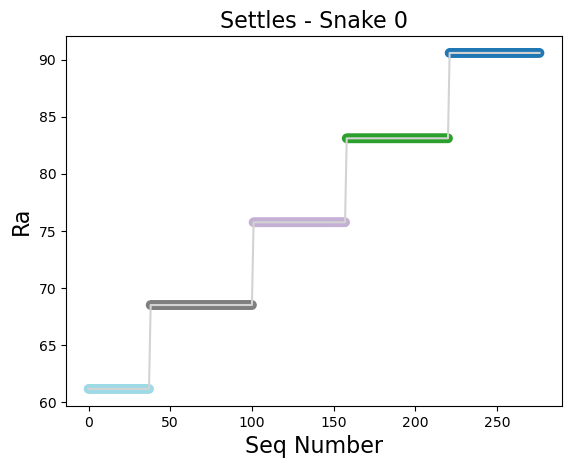

In [54]:
snake_id = 0
ix = keys[snake_id]
data['Calculated Ra wide'].iloc[ix].plot(color='lightgray')
plt.scatter(data.iloc[ix].index, data['Calculated Ra wide'].iloc[ix], 
            c=data['groups'].iloc[ix], cmap='tab20_r')

plt.title('Settles - Snake %i'%snake_id, fontsize=16)
plt.ylabel('Ra', fontsize=16)
plt.xlabel('Seq Number', fontsize=16)
plt.savefig('pointing_ra.png',dpi=100)

For each group (setlle point), I subtract the median (RA,DEC). The residuals are basically the telescope jitter.

In [55]:
base_alt = data['Calculated Alt wide'].to_numpy()
base_az = data['Calculated Az wide'].to_numpy()
snakes = data['snakes'].to_numpy()

# base_az = np.where(base_az>180, 180-base_az, base_az)
# base_ra = np.where(base_ra>180, 180-base_ra, base_ra)

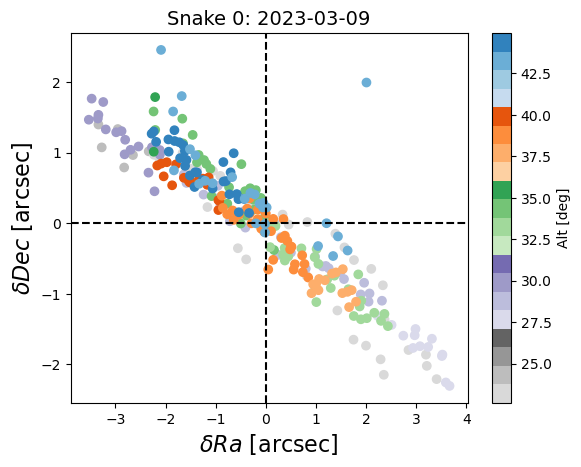

In [56]:
plt.scatter(res_ra[ix], res_dec[ix], c=base_alt[ix],cmap='tab20c_r')
plt.axvline(0,color='k',ls='--')
plt.axhline(0,color='k',ls='--')
plt.title('Snake %i: 2023-03-09'%snake_id,fontsize=14)
plt.xlabel(r'$\delta Ra$ [arcsec]',fontsize=16)
plt.ylabel(r'$\delta Dec$ [arcsec]',fontsize=16)
plt.colorbar(label='Alt [deg]')
plt.savefig('residual_radec.png',dpi=100)

We see a typical jitter amplitude of $0.5$ arcsec with some outliers.

In [15]:
def get_sigma_68(x):
    p16, p84 = np.nanpercentile(x, [16,84])
    return (p84-p16)/2.

def get_jitter(ra,dec):
    jra = get_sigma_68(ra)
    jdec = get_sigma_68(dec)
    return np.array([jra, jdec, np.hypot(jra,jdec)])

In [16]:
# Now I will compute the standard deviation (\sigma_{68}) for each snake

stds = []
for ix in keys:
    stds.append(get_jitter(res_ra[ix],res_dec[ix]))
stds = np.array(stds)

/Users/jesteves/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [17]:
_, sids, counts = np.unique(data['snakes'].to_numpy(), return_index=True, return_counts=True)
counts

array([46, 33, 33, 33, 33, 33, 33, 33, 33, 33, 12,  3, 21,  3,  3,  3,  3,
        9,  3,  9,  3,  3, 27, 33, 33])

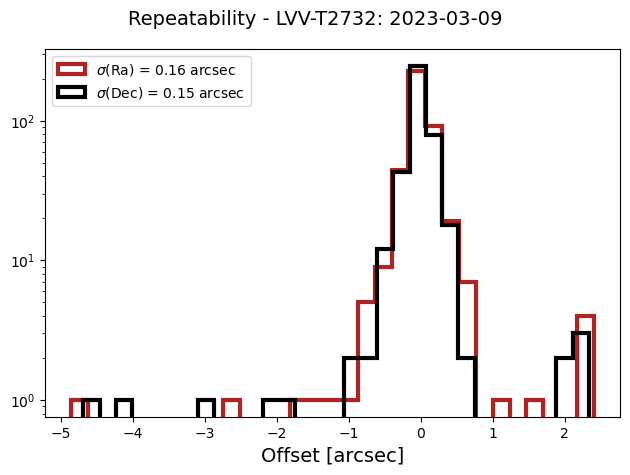

In [18]:
jra = get_sigma_68(res_ra)
jdec = get_sigma_68(res_dec)

_ = plt.hist(res_ra, bins=31, color='firebrick', histtype='step', lw=3, label='$\sigma$(Ra) = %.2f arcsec'%jra)
_ = plt.hist(res_dec, bins=31, color='k', histtype='step', lw=3, label='$\sigma$(Dec) = %.2f arcsec'%jdec)
plt.yscale('log')
plt.legend(loc=2)
plt.xlabel('Offset [arcsec]', fontsize=14)
plt.suptitle('Repeatability - LVV-T2732: 2023-03-09',fontsize=14)
plt.tight_layout()
plt.savefig('jitter_histogram.png',dpi=100)

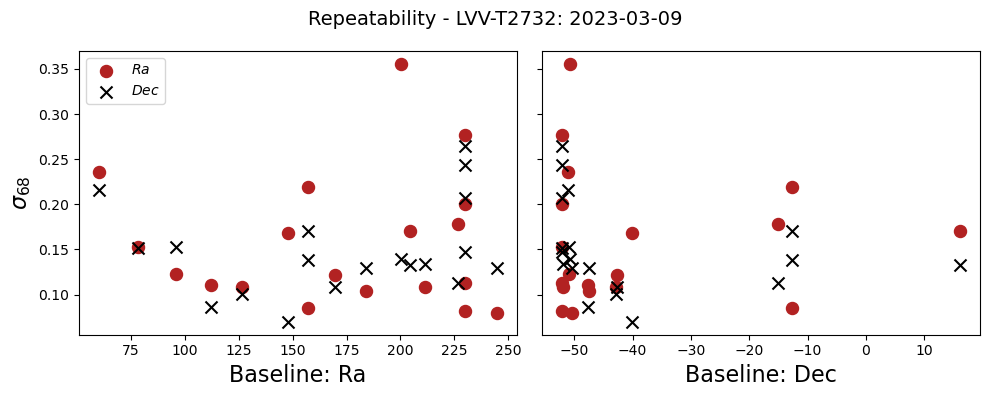

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax1.scatter(base_ra[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_dec[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_ra[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_dec[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=2)
# ax1.errorbar(base_ra[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')
# ax2.errorbar(base_dec[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Ra',fontsize=16)
ax2.set_xlabel('Baseline: Dec',fontsize=16)
fig.suptitle('Repeatability - LVV-T2732: 2023-03-09',fontsize=14)
fig.tight_layout()
plt.savefig('jitter_radec.png',dpi=100)

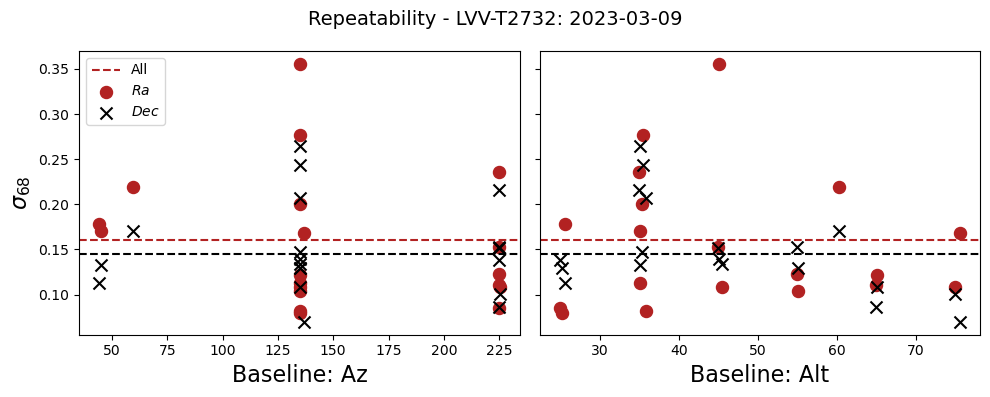

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax2.axhline(jra, c='firebrick', ls='--')
ax2.axhline(jdec, c='k', ls='--')

ax1.axhline(jra, c='firebrick', ls='--',label='All')
ax1.axhline(jdec, c='k', ls='--')

ax1.scatter(base_az[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_alt[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_az[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_alt[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=2)
# ax2.legend(loc=1)

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Az',fontsize=16)
ax2.set_xlabel('Baseline: Alt',fontsize=16)
fig.suptitle('Repeatability - LVV-T2732: 2023-03-09',fontsize=14)
fig.tight_layout()
plt.savefig('jitter_azalt.png',dpi=100)